In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev

from unseen import process_utils
from unseen import eva

Matplotlib is building the font cache; this may take a moment.


In [3]:
ds = xr.open_dataset('/g/data/xv83/dbi599/tc-jasper/rx5day_AGCD-CSIRO_r005_1900-2023_A-AUG_daintree-river.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:     (time: 125)
Coordinates:
  * time        (time) datetime64[ns] 1900-01-01T09:00:00 ... 2024-01-02T09:0...
    event_time  (time) object '1899-07-13' '1901-01-07' ... '2023-12-18'
Data variables:
    pr          (time) float32 nan 222.2 161.0 1.268e+03 ... 400.0 296.5 nan
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Jan 09 15:22:48 2024: /g/data/xv83/dbi...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [6]:
df = ds.to_dataframe()

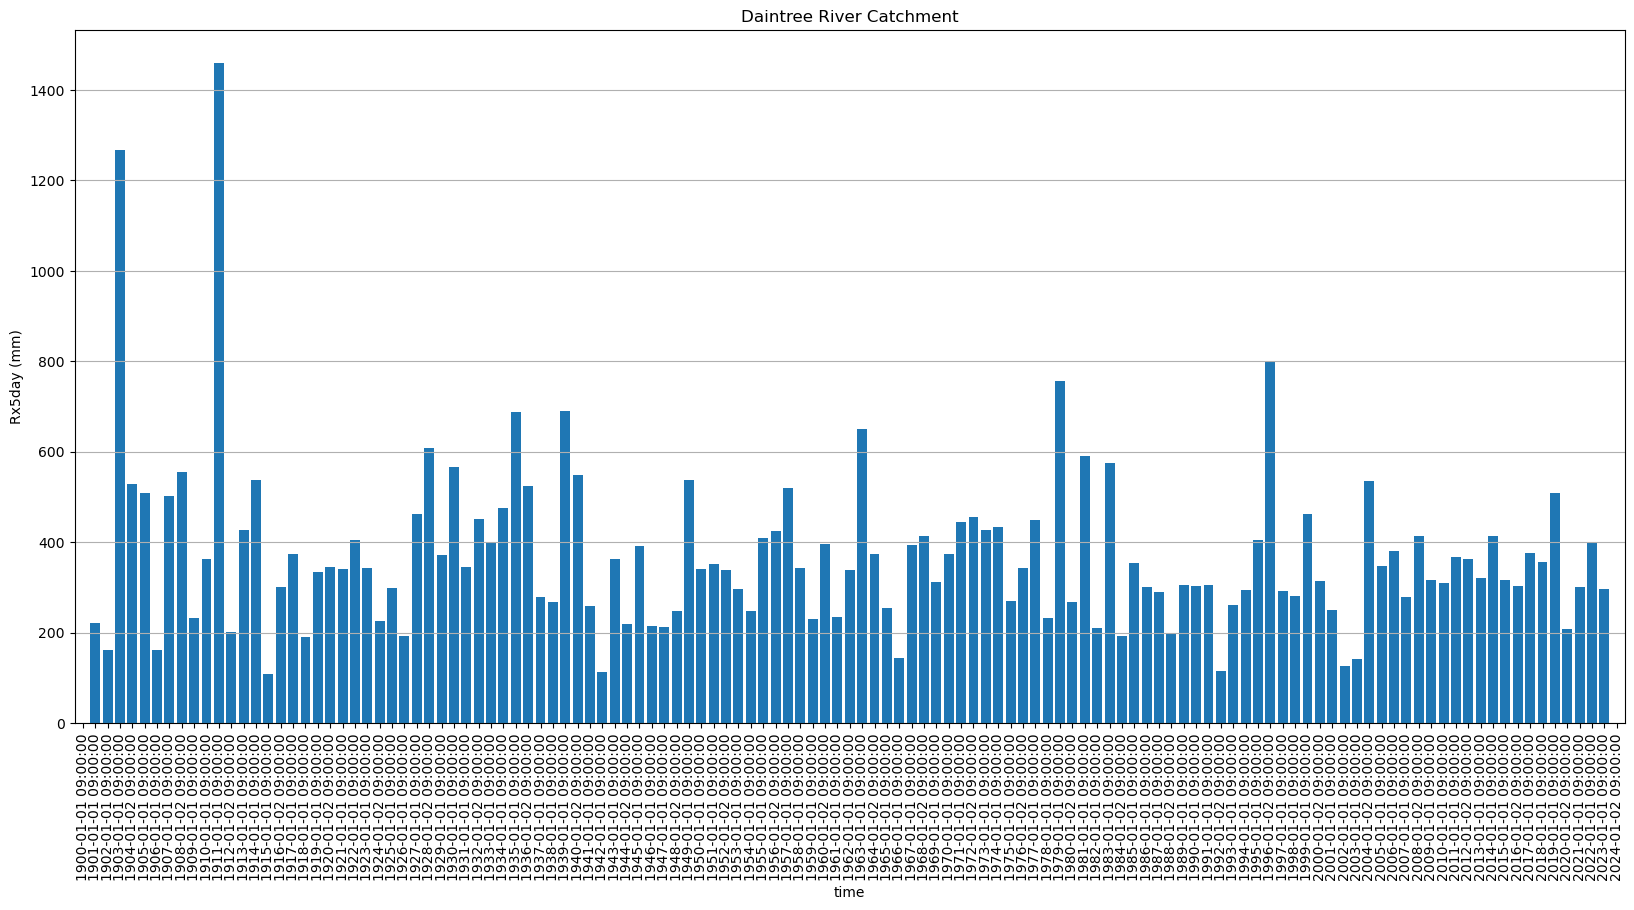

In [7]:
df['pr'].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel('Rx5day (mm)')
plt.title('Daintree River Catchment')
plt.grid(axis='y')
plt.show()

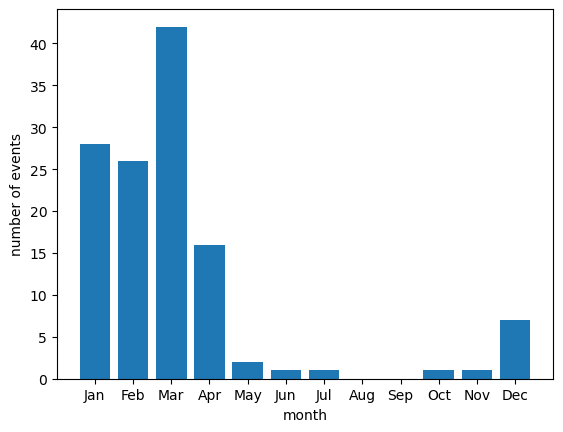

In [8]:
process_utils.plot_event_seasonality(df)

In [9]:
ranked_years = df.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

                              pr  event_time
time                                        
1911-01-01 09:00:00  1459.442017  1911-04-03
1903-01-01 09:00:00  1267.950684  1903-04-23
1996-01-02 09:00:00   799.335449  1996-03-08
1979-01-01 09:00:00   756.700500  1979-01-05
1939-01-01 09:00:00   689.864258  1939-03-25
1935-01-01 09:00:00   688.977478  1935-03-04
1963-01-01 09:00:00   650.727356  1963-04-10
1928-01-02 09:00:00   607.283936  1928-02-29
1981-01-01 09:00:00   589.572449  1981-01-13
1983-01-01 09:00:00   574.126343  1983-03-11


According to the [BoM Queensland Flood history](http://www.bom.gov.au/qld/flood/fld_history/floodsum_1910.shtml):
"1st April: Heavy rain in north Queensland. Record floods at Palmerville and Walsh River; big loss of stock. On the 1st, 2nd, and 3rd the Barron River was in flood at Kuranda; flood estimated to be the highest on record."

In [10]:
rx5day_max = ranked_years.iloc[0]['pr']

In [ ]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot()
eva.plot_gev_return_curve(
    ax,
    ds['pr'].values,
    rx5day_max,
    n_bootstraps=100,
    direction="exceedance",
    ylabel='rx5day (mm)',
    ylim=(0, 3000),
)
plt.show()

In [ ]:
agcd_shape, agcd_loc, agcd_scale = eva.fit_gev(agcd_ds['pr'].values)

event_probability = gev.sf(rx5day_max, agcd_shape, loc=agcd_loc, scale=agcd_scale)
event_return_period = 1. / event_probability
event_percentile = (1 - event_probability) * 100

print(f'{event_return_period:.0f} year return period')
print(f'{event_percentile:.2f}% percentile\n')

In [ ]:
# GEV analysis

gev23_shape, gev23_loc, gev23_scale = eva.fit_gev(ds.values)
gev22_shape, gev22_loc, gev22_scale = eva.fit_gev(ds.values[:-1])
    
fig, ax = plt.subplots(figsize=[10, 6])
gev_xvals = np.arange(0, 700)
ds.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5, label='Histogram')
gev23_pdf = gev.pdf(gev_xvals, gev23_shape, gev23_loc, gev23_scale)
plt.plot(gev_xvals, gev22_pdf, color='tab:gray', linewidth=4.0, label='GEV fit 1900-2022')
gev22_pdf = gev.pdf(gev_xvals, gev22_shape, gev22_loc, gev22_scale)
plt.plot(gev_xvals, gev21_pdf, color='black', linewidth=4.0, linestyle=':', label='GEV fit 1900-2021')
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) rx5day for the Daintree River catchment (AGCD)')
plt.xlim(0, 500)
plt.legend()
#plt.savefig(
#    '/g/data/xv83/dbi599/tc-jasper/figures/rx5day_histogram_AGCD_daintree-river.png',
#    bbox_inches='tight',
#    facecolor='white',
#)
plt.show()
    
event23_probability = gev.sf(event, gev23_shape, loc=gev23_loc, scale=gev23_scale)
event23_return_period = 1. / event23_probability
event23_percentile = (1 - event23_probability) * 100
print('# Full timeseries (1900-2023)')
print(f'{event23_return_period:.3f} year return period')
print(f'{event23_percentile:.2f}% percentile\n')
    
event22_probability = gev.sf(event, gev22_shape, loc=gev22_loc, scale=gev22_scale)
event22_return_period = 1. / event22_probability
event22_percentile = (1 - event22_probability) * 100
print('# No record timeseries (1900-2022)')
print(f'{event22_return_period:.3f} year return period')
print(f'{event22_percentile:.2f}% percentile')